#Install packages

In [ ]:
%%capture
!pip install datasets
!pip install git+https://github.com/huggingface/transformers.git
!pip install flax
!pip install git+https://github.com/deepmind/optax.git

In [ ]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
jax.local_devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

#Load Dataset

In [ ]:
from datasets import load_dataset, load_metric
import pprint

In [ ]:
dataset = 'sentiment140'
model_name = "roberta-base"

In [ ]:
raw_ds = load_dataset(dataset)
print(raw_ds)

Generating train split:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/498 [00:00<?, ? examples/s]

Dataset sentiment140 downloaded and prepared to /root/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query'],
        num_rows: 1600000
    })
    test: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query'],
        num_rows: 498
    })
})


In [ ]:
sorted_dataset = raw_ds.sort("sentiment")
shuffled_dataset = sorted_dataset.shuffle(seed=42)

In [ ]:
shuffled_ds = shuffled_dataset['train'].train_test_split(test_size=0.05)

In [ ]:
raw_ds_test = shuffled_ds['test']
raw_ds_train = shuffled_ds['train']

##Preprocess Data

In [ ]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained(model_name)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
import numpy as np

def prepocess_fn(examples):
    texts = ((examples['text'],))
    
    processed = tokenizer(*texts, 
                          max_length=128, 
                          truncation=True,
                          padding="max_length")
    lst = examples["sentiment"]
    for i in range(len(lst)):
      if lst[i] == 0:
        lst[i] = 0
      elif lst[i] == 4:
        lst[i] = 1
    processed["label"] = np.array(lst)
    return processed

In [ ]:
ds_test = raw_ds_test.map(prepocess_fn, batched=True, remove_columns=['text', 'date', 'user', 'sentiment', 'query'])
# ds_train = raw_ds_train.map(prepocess_fn, batched=True, remove_columns=['text', 'date', 'user', 'sentiment', 'query'])

  0%|          | 0/80 [00:00<?, ?ba/s]

#Finetune Flax Model

In [ ]:
import jax
import jax.numpy as jnp
from flax.training.common_utils import get_metrics, onehot, shard, shard_prng_key

def train_data_loader(rng, dataset, batch_size):
    steps_per_epoch = len(dataset) // batch_size
    perms = jax.random.permutation(rng, len(dataset)) #shuffle
    perms = perms[: steps_per_epoch * batch_size]  # Skip incomplete batch.
    perms = perms.reshape((steps_per_epoch, batch_size))
    for perm in perms:
        batch = dataset[perm]
        batch = {k: jnp.array(v) for k, v in batch.items()}
        batch = shard(batch)

        yield batch

def eval_data_loader(dataset, batch_size):
    for i in range(len(dataset) // batch_size):
        batch = dataset[i * batch_size : (i + 1) * batch_size]
        batch = {k: jnp.array(v) for k, v in batch.items()}
        batch = shard(batch)

        yield batch

In [ ]:
import flax
import optax
from itertools import chain
from tqdm.notebook import tqdm
from typing import Callable
from flax.training import train_state, checkpoints

In [ ]:
from transformers import FlaxRobertaForSequenceClassification, AutoConfig

num_labels = 2
seed = 0

config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
model = FlaxRobertaForSequenceClassification.from_pretrained(model_name, config=config, seed=seed)

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing FlaxRobertaForSequenceClassification: {('lm_head', 'layer_norm', 'scale'), ('lm_head', 'layer_norm', 'bias'), ('lm_head', 'dense', 'kernel'), ('lm_head', 'dense', 'bias'), ('lm_head', 'bias')}
- This IS expected if you are initializing FlaxRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FlaxRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: {('classifier', 'out_proj', 'kernel'), ('classifier', 'out_proj', 'bias'

In [ ]:
steps = 11_875
base_lr = 4e-5

In [ ]:
lr_schedule = optax.cosine_decay_schedule(init_value=-base_lr, decay_steps=steps)

gradient_transform = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.scale_by_adam(),
    optax.scale_by_schedule(lr_schedule),
)

In [ ]:
import flax.traverse_util

param_count = sum(x.size for x in jax.tree_leaves(model.params))
print(param_count)
flat_params = flax.traverse_util.flatten_dict(model.params)
print(jax.tree_map(jnp.shape, flat_params))

In [ ]:
import numpy as onp
from jax.experimental.host_callback import call

def make_update_fn(lr_fn):
  def train_step(state, batch, dropout_rng):
      labels = batch.pop("label")
      dropout_rng, new_dropout_rng = jax.random.split(dropout_rng)

      def cross_entropy_loss(logits, labels):
          xentropy = optax.softmax_cross_entropy(logits, onehot(labels, num_classes=num_labels))
          return jnp.mean(xentropy)

      def loss_fn(params):
          logits = state.apply_fn(**batch, params=params, dropout_rng=dropout_rng, train=True)[0]
          loss = cross_entropy_loss(logits, labels)
          return loss

      grad_fn = jax.value_and_grad(loss_fn)
      loss, grads = grad_fn(state.params)
      grads = jax.lax.pmean(grads, "batch")
      new_state = state.apply_gradients(grads=grads)
      metrics = jax.lax.pmean({"loss": loss, "lr": lr_fn(state.step)}, axis_name="batch")
      return new_state, metrics, new_dropout_rng

  return jax.pmap(train_step, axis_name='batch', donate_argnums=(0,))

In [ ]:
state = train_state.TrainState.create(
    apply_fn=model.__call__,
    params=model.params,
    tx=gradient_transform,
)

In [ ]:
update_fn_repl = make_update_fn(lr_fn=lr_schedule)

In [ ]:
rng = jax.random.PRNGKey(seed)
dropout_rngs = jax.random.split(rng, jax.local_device_count())
state = flax.jax_utils.replicate(state)

  0%|          | 1/11875 [02:08<423:42:59, 128.46s/it]

loss: 0.7431830763816833


  4%|▍         | 500/11875 [16:24<5:45:30,  1.82s/it]

loss: 0.4324820041656494


  8%|▊         | 1000/11875 [30:00<4:32:34,  1.50s/it]

loss: 0.3449941873550415


 13%|█▎        | 1500/11875 [43:13<4:43:44,  1.64s/it]

loss: 0.34981799125671387


 17%|█▋        | 2000/11875 [56:12<4:11:42,  1.53s/it]

loss: 0.3590662479400635


 21%|██        | 2500/11875 [1:08:51<3:53:48,  1.50s/it]

loss: 0.36974188685417175


 25%|██▌       | 3000/11875 [1:21:33<3:43:44,  1.51s/it]

loss: 0.3193337321281433


 29%|██▉       | 3500/11875 [1:34:08<3:25:07,  1.47s/it]

loss: 0.18742156028747559


 34%|███▎      | 4000/11875 [1:46:42<3:18:25,  1.51s/it]

loss: 0.22815144062042236


 38%|███▊      | 4500/11875 [1:59:20<3:05:27,  1.51s/it]

loss: 0.371621698141098


 42%|████▏     | 5000/11875 [2:12:06<2:53:42,  1.52s/it]

loss: 0.22293932735919952


 46%|████▋     | 5500/11875 [2:24:41<2:41:08,  1.52s/it]

loss: 0.32444554567337036


 51%|█████     | 6000/11875 [2:37:10<2:26:57,  1.50s/it]

loss: 0.32114824652671814


 55%|█████▍    | 6500/11875 [2:49:46<2:13:07,  1.49s/it]

loss: 0.23399853706359863


 59%|█████▉    | 7000/11875 [3:02:22<2:02:23,  1.51s/it]

loss: 0.2463584840297699


 63%|██████▎   | 7500/11875 [3:15:11<1:53:31,  1.56s/it]

loss: 0.3018610179424286


 67%|██████▋   | 8000/11875 [3:28:00<1:37:39,  1.51s/it]

loss: 0.23327237367630005


 72%|███████▏  | 8500/11875 [3:40:40<1:23:30,  1.48s/it]

loss: 0.20745344460010529


 76%|███████▌  | 9000/11875 [3:53:33<1:15:58,  1.59s/it]

loss: 0.171931654214859


 80%|████████  | 9500/11875 [4:06:44<1:01:14,  1.55s/it]

loss: 0.21134337782859802


 84%|████████▍ | 10000/11875 [4:19:36<50:54,  1.63s/it]

loss: 0.21933981776237488


 88%|████████▊ | 10500/11875 [4:32:20<36:16,  1.58s/it]

loss: 0.25783291459083557


 93%|█████████▎| 11000/11875 [4:45:16<22:29,  1.54s/it]

loss: 0.2318197339773178


 97%|█████████▋| 11500/11875 [4:58:14<09:34,  1.53s/it]

loss: 0.2838928997516632


100%|██████████| 11875/11875 [5:07:51<00:00,  1.56s/it]


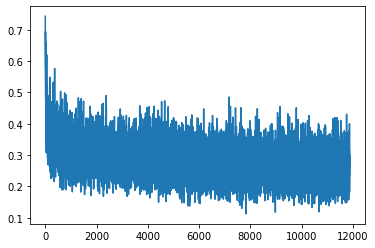

In [ ]:
import matplotlib.pyplot as plt
import tqdm
losses = []

for step, batch in zip(tqdm.trange(1, steps+1), train_data_loader(rng, ds_train, 128)):

  state, metrics, dropout_rngs = update_fn_repl(state, batch, dropout_rngs)
  loss = flax.jax_utils.unreplicate(metrics)['loss'].item()
  losses.append(loss)
  if step == 1 or step % 500 == 0:
    print("loss: {}".format(loss))

plt.plot(losses)

In [ ]:
roberta_apply_repl = jax.pmap(lambda params, inputs: state.apply_fn(**inputs, params=params, train=False))

def get_accuracy(params_repl):
  good = total = 0
  steps = len(ds_test)//128
  for _, batch in zip(tqdm.trange(steps), eval_data_loader(ds_test, 128)):
    labels = batch.pop('label')
    labels = jax.nn.one_hot(labels, num_classes=2)
    predicted = roberta_apply_repl(params_repl, batch)[0]
    is_same = predicted.argmax(axis=-1) == labels.argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

get_accuracy(state.params)

In [ ]:
import os
CKPT_DIR = '/content/ckpt'
os.makedirs(CKPT_DIR)
checkpoints.save_checkpoint(ckpt_dir="/content/checkpoint", target=flax.jax_utils.unreplicate(state), step=steps)

In [ ]:
save = '/content/test'
os.makedirs(save)
tokenizer.save_pretrained("/content/test")

('/content/test/tokenizer_config.json',
 '/content/test/special_tokens_map.json',
 '/content/test/vocab.json',
 '/content/test/merges.txt',
 '/content/test/added_tokens.json')

In [ ]:
from pip._internal.utils.misc import get_installed_distributions
import sys
#import numpy as np # imported to test whether numpy shows up, which it does!

def get_imported_packages():
    p = get_installed_distributions()
    p = {package.key:package.version for package in p}

    imported_modules = set(sys.modules.keys())
    
    imported_modules.remove('pip')

    modules = [(m, p[m]) for m in imported_modules if p.get(m, False)]

    return modules


def generate_requirements(filepath:str, modules):
    with open(filepath, 'w') as f:
        for module, version in modules:
            f.write(f"{module}=={version}\n")


generate_requirements('requirements.txt', get_imported_packages())

In [ ]:
!pip freeze > requirements.txt

#Load Checkpoints

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
!ls "/content/drive/MyDrive/tweets/"

In [ ]:
from transformers import AutoTokenizer, FlaxAutoModel
tokenizer_test = AutoTokenizer.from_pretrained("/content/drive/MyDrive/tweets/tokenizer")
tokenizer_test

In [ ]:
restored_state = checkpoints.restore_checkpoint(ckpt_dir="/content/drive/MyDrive/tweets/ckpt", target=state)

In [ ]:
devices = jax.local_devices()
restored_params = jax.device_put_replicated(restored_state.params,devices)

In [ ]:
roberta_apply_repl = jax.pmap(lambda params, inputs: restored_state.apply_fn(**inputs, params=params, train=False))

import tqdm

def get_accuracy_test(params_repl):
  good = total = 0
  steps = len(ds_test)//128
  for _, batch in zip(tqdm.trange(steps), eval_data_loader(ds_test, 128)):
    labels = batch.pop('label')
    labels = jax.nn.one_hot(labels, num_classes=2)
    predicted = roberta_apply_repl(params_repl, batch)[0]
    is_same = predicted.argmax(axis=-1) == labels.argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

get_accuracy_test(restored_params)

100%|██████████| 625/625 [02:26<00:00,  4.28it/s]


DeviceArray(0.9086875, dtype=float32)

#Predict

In [ ]:
line = []
lst = []
for i in range(20,28):
  line.append(raw_ds_train[i]['text'])

print(line)

for i in line:
  x = tokenizer_test.encode(i, max_length=32, truncation=True, padding="max_length")
  lst.append(jnp.array(x))

input_ids = jnp.array(lst)

["is slowly realizing the fact that her momz is moving to Europe to join Dad tmrw and she'll be living alone..getting abit sad. ", "it's the chack it out week  In this week, i will write 'check it out' in all my uptades here in twitter, haha", 'The computers and the Ethernet at school are so slow! ', 'grillen with the fam... SO HAPPY  one one person missing... YOU!!! (stop by if your close by )', "@smugfuzz I didn't realise you were such a patriot ", "@KrackofDawn oh no I'm sorry!  warning:  I'm going to wec tonight and will prob be tweeting...", 'My mouth hurts!!! ', 'curiosity killed the cat. fortunately, cats have 9 lives. ']


In [ ]:
input_ids.shape

(20, 32)

In [ ]:
features = model(input_ids, params = flax.jax_utils.unreplicate(restored_params))[0]

In [ ]:
print(jax.nn.softmax(features))
features.argmax(axis=-1)

[[0.50402266 0.49597734]
 [0.7022517  0.29774836]
 [0.66842246 0.3315775 ]
 [0.15572877 0.8442712 ]
 [0.20346019 0.7965398 ]
 [0.0934692  0.9065308 ]
 [0.00540776 0.9945923 ]
 [0.9838902  0.0161099 ]
 [0.00194198 0.9980581 ]
 [0.9572405  0.04275949]
 [0.03543773 0.9645623 ]
 [0.5872632  0.41273677]
 [0.0761805  0.9238195 ]
 [0.01654011 0.9834599 ]
 [0.9779465  0.02205354]
 [0.86811167 0.13188833]
 [0.6241653  0.37583467]
 [0.9755917  0.02440822]
 [0.03162333 0.9683766 ]
 [0.45197687 0.5480231 ]]


DeviceArray([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1], dtype=int32)

In [ ]:
for i in range(20,40):
  print(1 if raw_ds_train[i]['sentiment'] == 4 else 0, end = " ")

1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 

In [ ]:
x = jnp.array([1,4,6,9])
jax.nn.softmax(x)

DeviceArray([3.1741397e-04, 6.3754204e-03, 4.7108375e-02, 9.4619882e-01],            dtype=float32)